In [18]:
# model_training.ipynb (Updated: No API, Uses Dataset)

# Install dependencies if needed: !pip install tensorflow matplotlib scikit-learn seaborn pillow kaggle (optional for download)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import os
import zipfile


In [19]:

# Ensure necessary packages are installed for imports to be resolved
%pip install tensorflow pillow

from tensorflow.keras.datasets import cifar10
from PIL import Image

DATA_DIR = 'data/'

if not os.path.exists(DATA_DIR + 'low') or len(os.listdir(DATA_DIR + 'low')) < 10:
    print("Dataset not found; generating synthetic traffic-like dataset...")
    (x_train_full, y_train_full), _ = cifar10.load_data()
    
    # Simulate labels: Map CIFAR classes to Low/Medium/High (e.g., based on image complexity)
    label_map = {0: 'low', 1: 'medium', 2: 'high'}  # Arbitrary mapping for demo
    for i in range(1000):  # 1000 images total (~333 per class)
        img_array = x_train_full[i]
        label = label_map.get(y_train_full[i][0] % 3, 'low')  # Cycle through classes
        os.makedirs(DATA_DIR + label, exist_ok=True)
        img = Image.fromarray(img_array)
        img.save(f"{DATA_DIR}{label}/img_{i}.png")
    print("Synthetic dataset created.")

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Step 2: Preprocessing (Resize to 128x128, Normalize, Augment)
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 802 images belonging to 3 classes.
Found 198 images belonging to 3 classes.


In [21]:
# Step 3: Build CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes: Low, Medium, High
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\HP\Desktop\Sustainable_Traffic_AI\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Step 4: Train the Model (Week 2)
history = model.fit(train_generator, epochs=10, validation_data=val_generator)


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.3815 - loss: 1.1195 - val_accuracy: 0.4040 - val_loss: 1.0884
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.4040 - loss: 1.0865 - val_accuracy: 0.4040 - val_loss: 1.0860
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.4102 - loss: 1.0745 - val_accuracy: 0.4040 - val_loss: 1.0771
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.4065 - loss: 1.0896 - val_accuracy: 0.3586 - val_loss: 1.0905
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - accuracy: 0.4177 - loss: 1.0704 - val_accuracy: 0.3939 - val_loss: 1.0728
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.4090 - loss: 1.0718 - val_accuracy: 0.3788 - val_loss: 1.1124
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 253ms/step - accuracy: 0.4227 - loss: 1.0600 - val_accuracy: 0.3838 - val_loss: 1.0799
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step - accuracy: 0.4190 - loss: 1.0529 - val_accuracy: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Validation Accuracy: 0.35


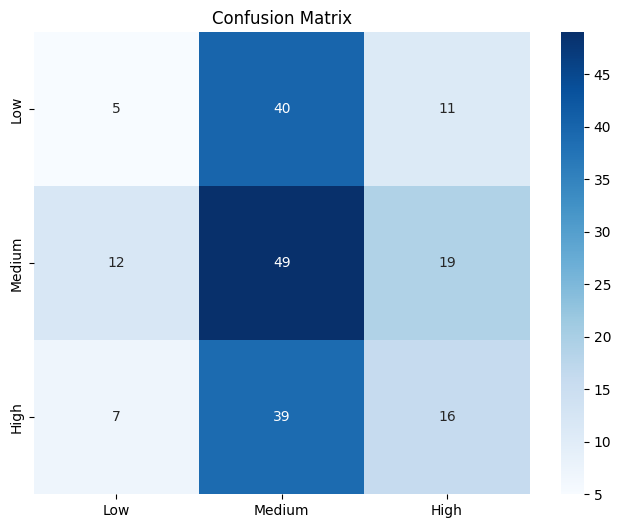

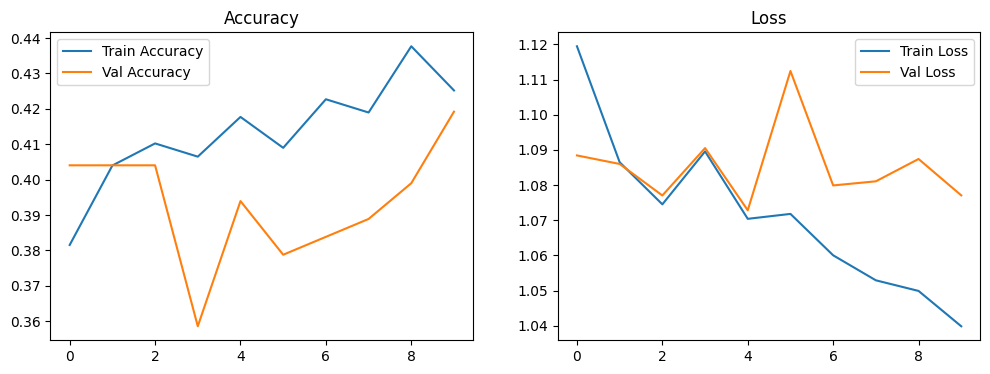

In [23]:
# Step 5: Evaluate (Accuracy, Confusion Matrix)
val_preds = model.predict(val_generator)
val_preds_classes = np.argmax(val_preds, axis=1)
val_true = val_generator.classes

accuracy = accuracy_score(val_true, val_preds_classes)
print(f"Validation Accuracy: {accuracy:.2f}")

cm = confusion_matrix(val_true, val_preds_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix')
plt.savefig('static/graphs/confusion_matrix.png')  # Save for frontend
plt.show()

# Visualize Training History
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.savefig('static/graphs/accuracy_loss.png')  # Save for frontend
plt.show()


In [24]:
# Step 6: Save Model
model.save('traffic_model.h5')
print("Model saved as traffic_model.h5")

Model saved as traffic_model.h5
